<a href="https://colab.research.google.com/github/ParitoshP702/Tensorflow_computer_vision/blob/main/Adults_vs_children.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#extracting the zip file
import zipfile
zip_ref=zipfile.ZipFile("adults_vs_children.zip")
zip_ref.extractall()
zip_ref.close()

In [3]:
!ls train

adults	children


In [4]:
#creating a numpy array of class names
import pathlib
import numpy as np
dir_path = pathlib.Path("train")
class_names = np.array(sorted([item.name for item in dir_path.glob('*')]))

In [5]:
class_names

array(['adults', 'children'], dtype='<U8')

In [6]:
#now moving ahead next step in our preprocessing stage ...creating trainiong and test set
train_dir = "train"
test_dir = "test"


In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1/255.)
train_data = train_datagen.flow_from_directory(train_dir,batch_size = 32, target_size = (320,370),seed = 42, class_mode = "binary")
test_data = test_datagen.flow_from_directory(test_dir, batch_size =32, target_size = (320,370), seed = 42, class_mode = "binary")


Found 680 images belonging to 2 classes.
Found 120 images belonging to 2 classes.


Now we are hgoing to build our own convolutional neural network model architecture to learn the given dataset

In [8]:
from tensorflow.keras import layers
from tensorflow.keras.layers import  Dense,Conv2D,Flatten
model_0 = tf.keras.Sequential([
    Conv2D(filters = 10, kernel_size = 3, strides = 1, activation = "relu",input_shape = (320,370,3)),
    Conv2D(10,3,activation = "relu"),
    tf.keras.layers.MaxPool2D(pool_size = 2),
    Conv2D(10,3,activation = "relu"),
    Conv2D(10,3,activation = "relu"),
    tf.keras.layers.MaxPool2D(2),
    Flatten(),
    Dense(1,activation = "sigmoid")
])

In [9]:
#compiling our model
model_0.compile(loss = "binary_crossentropy", optimizer = tf.keras.optimizers.Adam(), metrics = ["accuracy"])

In [10]:
#cteating a function for our tensorboard callbacks
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensor_board_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
  return tensor_board_callback
  


In [11]:
#fitting our model using the history object
history_0 = model_0.fit(train_data, epochs = 5, steps_per_epoch = len(train_data), validation_data = test_data, validation_steps = len(test_data),
                         callbacks = [create_tensorboard_callback(dir_name = "VISION",experiment_name = "model_0")] )

Epoch 1/5
22/22 [==============================] - 15s 200ms/step - loss: 0.7611 - accuracy: 0.4500 - val_loss: 0.6918 - val_accuracy: 0.4917
Epoch 2/5
22/22 [==============================] - 4s 161ms/step - loss: 0.6838 - accuracy: 0.5794 - val_loss: 0.6802 - val_accuracy: 0.5917
Epoch 3/5
22/22 [==============================] - 4s 161ms/step - loss: 0.6607 - accuracy: 0.5809 - val_loss: 0.6890 - val_accuracy: 0.5000
Epoch 4/5
22/22 [==============================] - 4s 160ms/step - loss: 0.6061 - accuracy: 0.6882 - val_loss: 0.7115 - val_accuracy: 0.5333
Epoch 5/5
22/22 [==============================] - 4s 162ms/step - loss: 0.4796 - accuracy: 0.7926 - val_loss: 0.7644 - val_accuracy: 0.5333


In [12]:
#We will now try to plot the loss curves of our model
import matplotlib.pyplot as plt
def plot_loss_curves(history):
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]
  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]
  epochs = range(len(loss))
  plt.plot(epochs, val_loss,label = "val_loss")
  plt.plot(epochs, loss, label = "loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.figure()
  plt.plot(epochs,accuracy, label = "accuracy")
  plt.plot(epochs, val_accuracy, label = "val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")

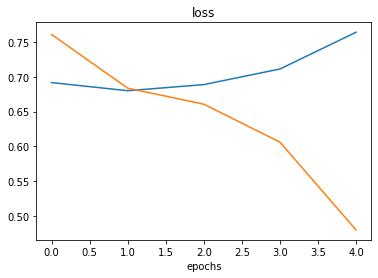

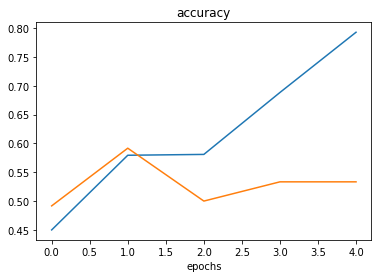

In [13]:
plot_loss_curves(history_0)

Seems that our data is overfitting a bit, hence , we would try to reduce overfitting using data augmentation but before doing that we would first evaluate various other metrics related to our dataset namely, precision, recall,F1 score and we would also create a custom function to evaluate the confusion matrix of our dataset.

We will try to create an improved model using data augmentation using functional API(we created earlier model using sequential API)

In [14]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
train_data_f = image_dataset_from_directory(train_dir, label_mode = "binary", image_size = (320,370), batch_size= 32, seed = 42, shuffle = False)
test_data_f = image_dataset_from_directory(test_dir, label_mode = "binary", image_size = (320,370),batch_size = 32,seed = 42, shuffle = False)

Found 680 files belonging to 2 classes.
Found 120 files belonging to 2 classes.


Creating a model checkpoint callback

# We are now going to use a transfer learning approach . We will use the inbuilt EfficientNetB0 model(as a base model)
## And then fine tune our model by unfreezing some of the layers and see whether this model performs better than our previously created model. 

In [15]:
#creating the data augmentation layer usinh Sequential API
from tensorflow.keras.layers.experimental import preprocessing
data_augmentation = tf.keras.Sequential([
    
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2)
], name = "data_augmentation_layer")

In [16]:
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False
inputs = layers.Input(shape = (320,370,3), name = "Input_layer")
x = data_augmentation(inputs)
x = base_model(x,training = False)
x= layers.GlobalAveragePooling2D(name = "Global_average_pooling_layer")(x)
outputs = layers.Dense(1,activation = "sigmoid",name = "output_layer")(x)

16719872/16705208 [==============================] - 0s 0us/step


In [17]:
model_1 = tf.keras.Model(inputs,outputs)

In [18]:
#compiiling our model
model_1.compile(loss = "binary_crossentropy", optimizer = tf.keras.optimizers.Adam(), metrics = ["accuracy"])

In [19]:
history_1 = model_1.fit(train_data_f, epochs = 5, steps_per_epoch = len(train_data_f), validation_data = test_data_f, validation_steps = len(test_data_f))

Epoch 1/5
22/22 [==============================] - 27s 953ms/step - loss: 0.9577 - accuracy: 0.3206 - val_loss: 0.6876 - val_accuracy: 0.5583
Epoch 2/5
22/22 [==============================] - 15s 691ms/step - loss: 0.5913 - accuracy: 0.7235 - val_loss: 0.6308 - val_accuracy: 0.6500
Epoch 3/5
22/22 [==============================] - 15s 708ms/step - loss: 0.6230 - accuracy: 0.6750 - val_loss: 0.5915 - val_accuracy: 0.7083
Epoch 4/5
22/22 [==============================] - 15s 705ms/step - loss: 0.5957 - accuracy: 0.6765 - val_loss: 0.5618 - val_accuracy: 0.7667
Epoch 5/5
22/22 [==============================] - 14s 614ms/step - loss: 0.5656 - accuracy: 0.7206 - val_loss: 0.5437 - val_accuracy: 0.7750


In [20]:
feature_extraction_results = model_1.evaluate(test_data_f)

4/4 [==============================] - 1s 160ms/step - loss: 0.5437 - accuracy: 0.7750


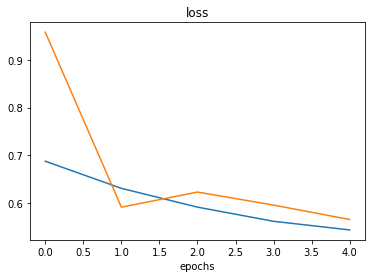

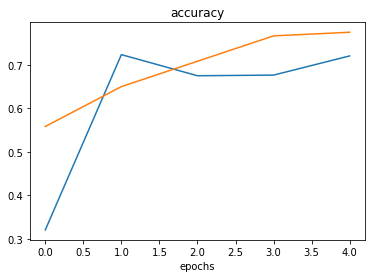

In [21]:
#plotting the loss curves of our model
plot_loss_curves(history_1)

## Hence we can see clearly how using feature extraction improves the validation accuracy of our model, now we will fine tune the model by unfreezing some of its layers

In [22]:
for layer in model_1.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fa62c12ea90> True
<keras.engine.sequential.Sequential object at 0x7fa62c1c2150> True
<keras.engine.functional.Functional object at 0x7fa6130d1590> False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7fa62c1c2910> True
<keras.layers.core.dense.Dense object at 0x7fa6121773d0> True


In [23]:
#clearly hte layer with index 2 is not trainable, we will further visualize this layer(or its sublayers, to be specific)
for layer in model_1.layers[2].layers:
  print(layer,layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fa6802c2f90> False
<keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x7fa62c293250> False
<keras.layers.preprocessing.normalization.Normalization object at 0x7fa62c23bf90> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7fa680041510> False
<keras.layers.convolutional.Conv2D object at 0x7fa6803209d0> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fa62c162710> False
<keras.layers.core.activation.Activation object at 0x7fa6800b6610> False
<keras.layers.convolutional.DepthwiseConv2D object at 0x7fa62c110d10> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fa62c117890> False
<keras.layers.core.activation.Activation object at 0x7fa680349990> False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7fa62c117f50> False
<keras.layers.core.reshape.Reshape object at 0x7fa62c0aabd0> False
<keras.layers.convolutional.Conv2D object at 0x7

In [24]:
#we are going to unfreeze the last 10 layers of the base  model and fine tune them
base_model.trainable  =True
for layer in base_model.layers[:-5]:
  layer.trainable = False


In [25]:
#Now we will compile our model again with 10 times lower learning rate
model_1.compile(loss = "binary_crossentropy", optimizer = tf.keras.optimizers.Adam(0.0001), metrics = ["accuracy"])


In [26]:
#Now we will fit our new model for exttra 5(i.e , total 0f 10) epochs
history_fine_tuned = model_1.fit(train_data_f, epochs = 10, steps_per_epoch = len(train_data), validation_data = test_data_f, validation_steps = len(test_data_f))

Epoch 1/10
22/22 [==============================] - 22s 726ms/step - loss: 0.8500 - accuracy: 0.5426 - val_loss: 0.5530 - val_accuracy: 0.7167
Epoch 2/10
22/22 [==============================] - 15s 652ms/step - loss: 0.4391 - accuracy: 0.8162 - val_loss: 0.5223 - val_accuracy: 0.7417
Epoch 3/10
22/22 [==============================] - 13s 580ms/step - loss: 0.5338 - accuracy: 0.7309 - val_loss: 0.4872 - val_accuracy: 0.8000
Epoch 4/10
22/22 [==============================] - 15s 663ms/step - loss: 0.4693 - accuracy: 0.7750 - val_loss: 0.4737 - val_accuracy: 0.8000
Epoch 5/10
22/22 [==============================] - 12s 573ms/step - loss: 0.4451 - accuracy: 0.8103 - val_loss: 0.4621 - val_accuracy: 0.8083
Epoch 6/10
22/22 [==============================] - 14s 614ms/step - loss: 0.4355 - accuracy: 0.8029 - val_loss: 0.4523 - val_accuracy: 0.7917
Epoch 7/10
22/22 [==============================] - 13s 577ms/step - loss: 0.4257 - accuracy: 0.8103 - val_loss: 0.4471 - val_accuracy: 0.8167

In [27]:
results_fine_tuned = model_1.evaluate(test_data_f)

4/4 [==============================] - 1s 161ms/step - loss: 0.4261 - accuracy: 0.8000


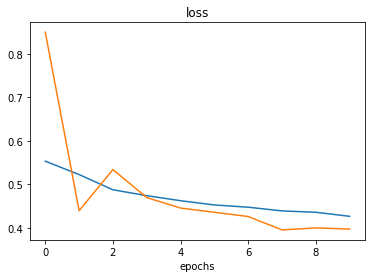

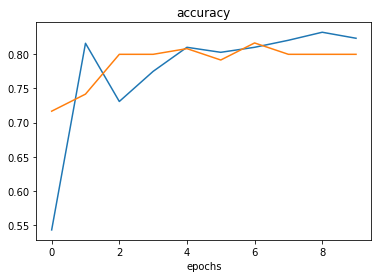

In [28]:
#plotiing the loss curves of our best model yet
plot_loss_curves(history_fine_tuned)

In [29]:
#prediction probablities of our model
pred_probs = model_1.predict(test_data_f, verbose = 1)

4/4 [==============================] - 2s 178ms/step


In [30]:
pred_probs.shape

(120, 1)

In [31]:
#constructing the pred classes from threr above prediction probablities
pred_classes = tf.round(tf.squeeze(pred_probs))

In [32]:
pred_classes

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1.,
       0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1.,
       1.], dtype=float32)>

In [33]:
#Now we need to obtain our test labels and in order to get them we need to unravel our batch dataset
test_labels = []#empty list to store the labels
for images,labels in test_data_f.unbatch():
  test_labels.append(tf.round(labels.numpy()))

In [34]:
true_labels = tf.squeeze(test_labels)

In [35]:
#Now we can evaluate models prediction to find the accuracy score using sklearn library
from sklearn.metrics import accuracy_score 
sklearn_accuracy = accuracy_score(y_true = true_labels, y_pred = pred_classes)
  

In [36]:
sklearn_accuracy

0.8

## Now we will create a general function to calculate various evaluation metrics of our best model till now, metrics namely , accuracy, precision, recall, F1_score

In [37]:
from sklearn.metrics import precision_recall_fscore_support
def calculate_results(y_true, y_preds):
    accuracy = accuracy_score(y_true = y_true,y_pred = y_preds)
    precision, recall, f1_score,_ = precision_recall_fscore_support(y_true = y_true, y_pred = y_preds, average = "weighted")
    return accuracy, precision, recall, f1_score

In [38]:
calculate_results(tf.squeeze(true_labels), pred_classes)

(0.8, 0.8, 0.8, 0.8000000000000002)

## 

In [45]:
import itertools
from sklearn.metrics import confusion_matrix
def create_confusion_matrix(y_true, y_preds):
  figsize = (10,10)
  cm = confusion_matrix(y_true, y_preds)
  cm_norm = cm.astype("float")/cm.sum(axis = 1)[:np.newaxis]#normalizing our confusion matrix
  n_classes = cm.shape[0]
  #Lets pretiffy it
  fig, ax = plt.subplots(figsize = figsize)
  #Create a matrix plot
  cax = ax.matshow(cm, cmap = plt.cm.Blues)
  fig.colorbar(cax)
  #Create classes
  classes = False
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  ax.set(title = "Confusion_Matrix",
           xlabel = "Predicted_Label",
           ylabel = "True Label",
           xticks = np.arange(n_classes),
           yticks = np.arange(n_classes),
           xticklabels = labels,
           yticklabels = labels)
    


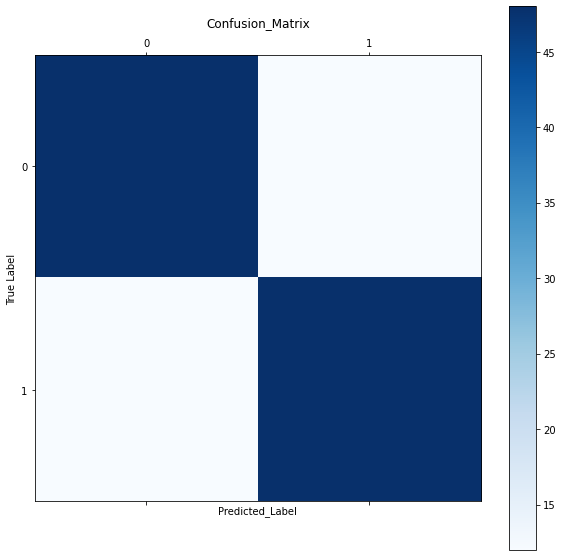

In [46]:
create_confusion_matrix(true_labels, pred_classes)

##Visualising our models

In [58]:
from tensorflow.keras.utils import plot_model
def plot_the_model(model):
  plot_model(model)

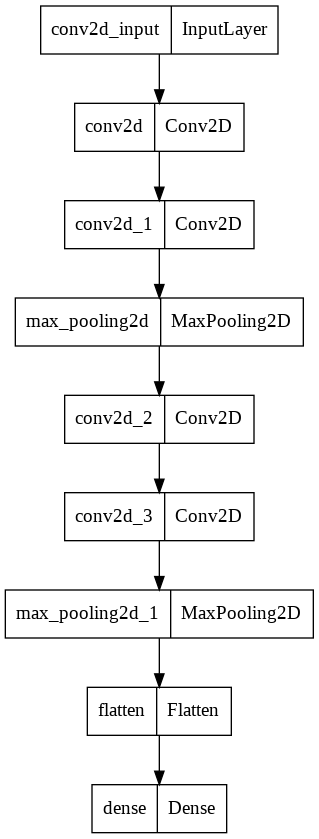

In [59]:
#Our self made architecture
plot_model(model_0)

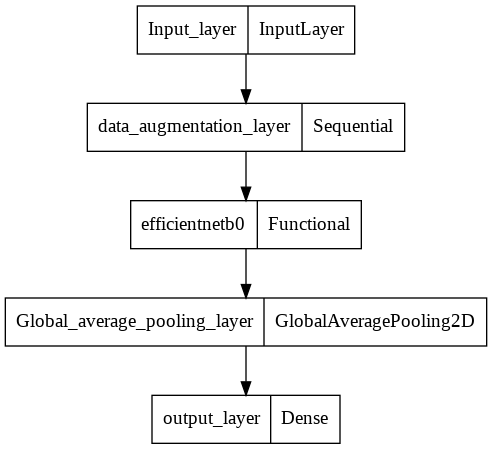

In [60]:
#plotting the efficientnet model
plot_model(model_1)